In [22]:
from ase.io import read, write
from ase.visualize import view

atoms = read('TiN.cif')
view(atoms) 

<Popen: returncode: None args: ['c:\\Users\\ameer\\miniforge3\\envs\\ase\\py...>

In [15]:
atoms = read('ZrN.cif')
view(atoms)

<Popen: returncode: None args: ['c:\\Users\\ameer\\miniforge3\\envs\\ase\\py...>

In [19]:
atoms = read('ZrN.poscar')
view(atoms)
write('ZrN.cif', atoms)

In [ ]:
from ase.io import read, write
from ase.visualize import view
from ase.calculators.espresso import Espresso
import os

#crystals = ['TiN', 'ZrN', 'NbN', 'ScN', 'VN']
crystals = [ 'ZrN']
pseudopotentials = {'Ti': 'ti_pbe_v1.4.uspp.F.UPF',
                    'Zr': 'Zr_pbe_v1.uspp.F.UPF',
                    'Nb': 'Nb.pbe-spn-kjpaw_psl.0.3.0.UPF',
                    'Sc': 'Sc_ONCV_PBE-1.0.oncvpsp.upf',
                    'V': 'v_pbe_v1.4.uspp.F.UPF',
                    'N': 'N.pbe-n-radius_5.UPF'}

ecutwfc_values_ev = range(350, 551, 25)  # 350, 375, 400, ..., 550
eV_to_Ry = 1.0 / 13.6057  # Conversion factor from eV to Ry

# Dictionary to store energies for table printing
energies_table = {ecut: {} for ecut in ecutwfc_values_ev}

for crystal in crystals:
    # Create an output directory for each crystal
    output_dir = f'{crystal}_calculations'
    os.makedirs(output_dir, exist_ok=True) # Creates directory if it doesn't exist

    atoms = read(f'{crystal}.cif')

    # Ensure all necessary pseudopotentials are in the dictionary for the calculator
    calc_pseudopotentials = {}
    for symbol in atoms.get_chemical_symbols():
        if symbol not in pseudopotentials:
            raise ValueError(f"Pseudopotential for {symbol} not found in the 'pseudopotentials' dictionary.")
        calc_pseudopotentials[symbol] = pseudopotentials[symbol]

    for ecutwfc_ev in ecutwfc_values_ev:
        # Convert to Ry for each cutoff value
        ecutwfc_ry = ecutwfc_ev * eV_to_Ry

        input_settings = {
            'control': {
                'calculation': 'scf',
                'prefix': crystal,
                'outdir': output_dir, # Set the output directory for QE
            },
            'system': {
                'ecutwfc': ecutwfc_ry,  # Wavefunction cutoff in Ry
                'ecutrho': ecutwfc_ry * 8,  # Charge density cutoff
                'occupations': 'smearing',
                'smearing': 'gaussian',
                'degauss': 0.01,
            },
            'electrons': {
                'conv_thr': 1.0e-8, # Example: add an electronic convergence threshold
            },
        }

        # Define k-points
        kpts = (5, 5, 5)

        # Initialize and run the calculator
        calc = Espresso(pseudopotentials=calc_pseudopotentials,
                        input_data=input_settings,
                        kpts=kpts)
        atoms.set_calculator(calc)

        # THIS IS THE CRUCIAL INDENTATION FIX:
        # The try-except block needs to be inside the inner loop
        # so that a calculation is attempted for each crystal and each ecutwfc.
        try:
            energy = atoms.get_potential_energy()
            energies_table[ecutwfc_ev][crystal] = energy
            print(f"Calculated {crystal} with ecutwfc: {ecutwfc_ev} eV, Energy: {energy:.4f} eV")
        except Exception as e:
            energies_table[ecutwfc_ev][crystal] = "Failed"
            print(f"Calculation failed for {crystal} with ecutwfc: {ecutwfc_ev} eV. Error: {e}")

# --- Output results to a file ---
output_filename = "crystal_e.txt"

with open(output_filename, 'w') as f: # Open the file in write mode ('w')
    f.write("\n" + "="*80 + "\n")
    f.write("Final Results:\n")
    f.write("="*80 + "\n")

    # Header
    header = f"{'ecutwfc (eV)':<15}" + "".join([f"{crystal:>15}" for crystal in crystals])
    f.write(header + "\n") # Write header to file
    f.write("-" * len(header) + "\n") # Write separator to file

    # Data rows
    for ecutwfc_ev in ecutwfc_values_ev:
        row = f"{ecutwfc_ev:<15}"
        for crystal in crystals:
            energy = energies_table[ecutwfc_ev].get(crystal, "N/A")
            if isinstance(energy, float):
                row += f"{energy:>15.4f}"
            else:
                row += f"{energy:>15}"
        f.write(row + "\n") # Write each data row to file

    f.write("="*80 + "\n") # Write final separator to file

print(f"\nResults saved to {output_filename}") # Inform the user that the file has been created
print("="*80)

Reading data from 'crystal_e_convergence.csv'...
Data successfully parsed.

Convergence plot saved to ecutwfc_convergence_subplots_plot.png


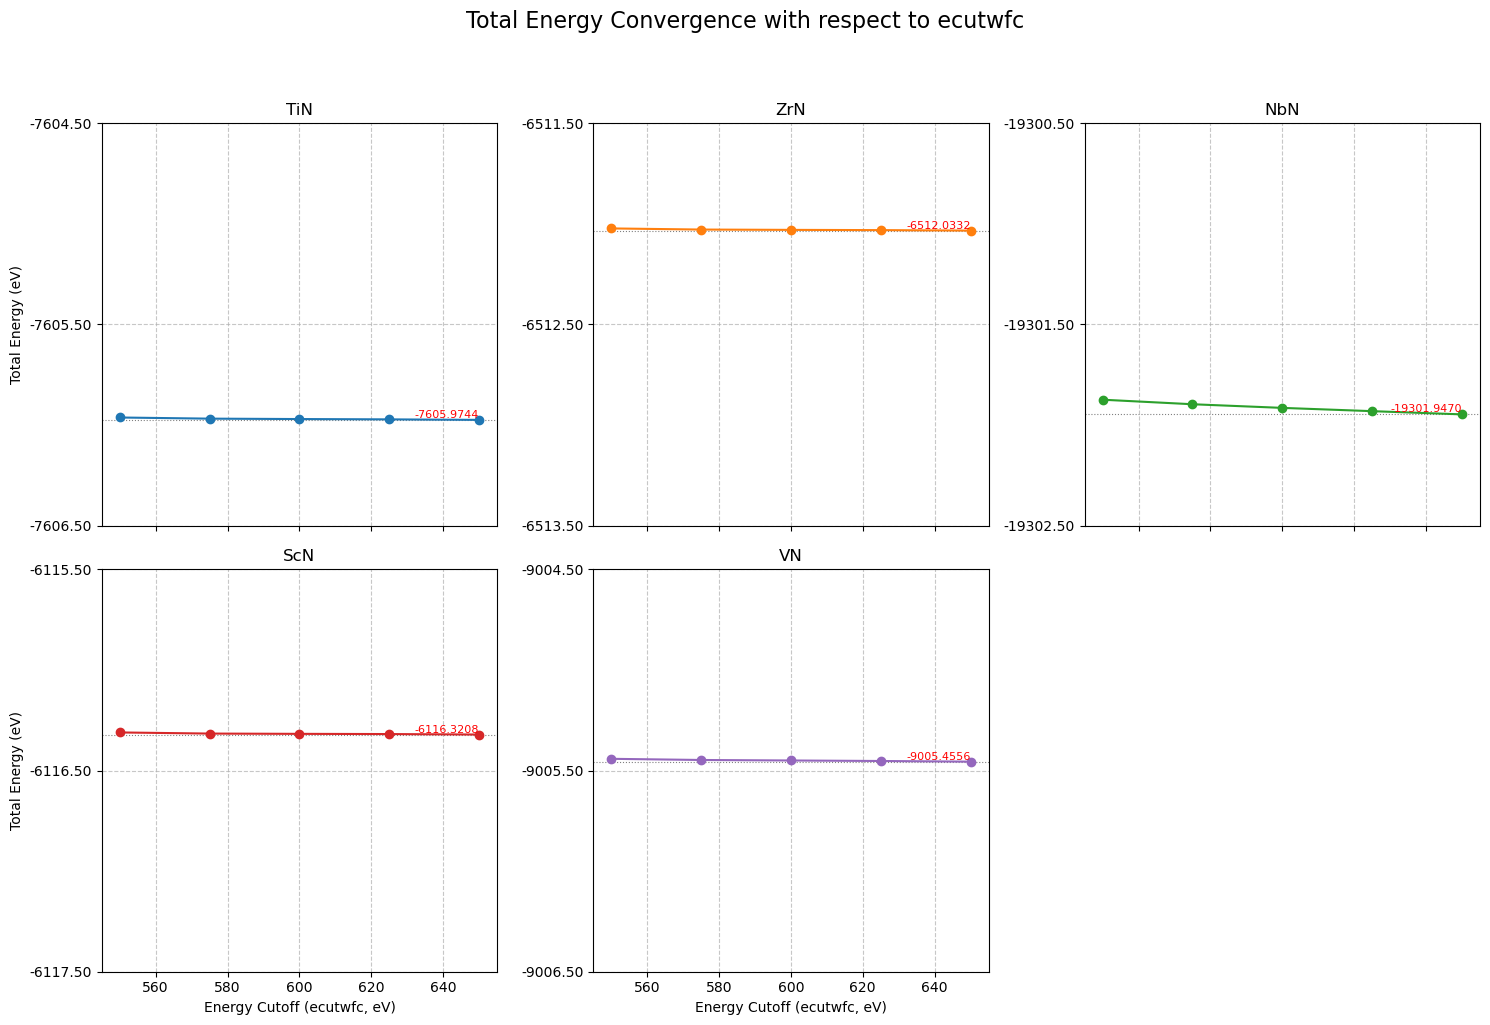

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv # We now need this to read CSV files

# --- Configuration for reading the CSV file ---
input_filename = "crystal_e_convergence.csv" # Changed to CSV filename

# --- Data structures to hold parsed data ---
ecutwfc_values_ev = []
# This will store data like {crystal_name: {ecutwfc_val: energy_val, ...}}
energies_data = {}
all_crystal_names = [] # To store the order of crystals from the header

# --- Read and Parse the crystal_e_convergence.csv file ---
if not os.path.exists(input_filename):
    print(f"Error: The file '{input_filename}' was not found in the current directory.")
    print("Please make sure you have run the calculation script to generate this CSV file.")
    exit() # Exit the script if the file doesn't exist

print(f"Reading data from '{input_filename}'...")

with open(input_filename, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Read header row
    header = next(reader) # Reads the first line which is the header
    
    # The first element is 'ecutwfc (eV)', the rest are crystal names
    # We need to clean the crystal names from potential leading/trailing spaces
    all_crystal_names = [name.strip() for name in header[1:]] 

    # Initialize inner dictionaries for each crystal in energies_data
    for crystal_name in all_crystal_names:
        energies_data[crystal_name] = {}

    # Parse data rows
    for row in reader:
        if not row: # Skip empty rows
            continue
        try:
            ecut = int(float(row[0])) # Convert ecutwfc from string to int
            if ecut not in ecutwfc_values_ev:
                ecutwfc_values_ev.append(ecut)
            
            for j, crystal_name in enumerate(all_crystal_names):
                # Data for crystals starts from the second column (index 1) in CSV
                energy_str = row[j + 1].strip() 
                if energy_str == "Failed" or energy_str == "N/A":
                    energies_data[crystal_name][ecut] = energy_str # Store as string
                else:
                    energies_data[crystal_name][ecut] = float(energy_str)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse row: '{row}' - Error: {e}")
            continue

# Ensure ecutwfc_values_ev is sorted (important for plotting order)
ecutwfc_values_ev.sort()

print("Data successfully parsed.")

### Plotting the Convergence in Subplots

# Determine the number of rows and columns for subplots
num_crystals = len(all_crystal_names)
n_cols = 3 # You can adjust this number of columns
n_rows = (num_crystals + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True)
axes = axes.flatten() # Flatten the axes array for easy iteration

fig.suptitle('Total Energy Convergence with respect to ecutwfc', fontsize=16, y=1.02)

# Define the desired Y-axis increment
Y_AXIS_INCREMENT = 1 # eV

# Iterate through each crystal and plot on its own subplot
for i, crystal in enumerate(all_crystal_names):
    ax = axes[i] # Get the current subplot axis
    
    crystal_energies = []
    corresponding_ecuts = []

    for ecut_val in ecutwfc_values_ev:
        energy = energies_data[crystal].get(ecut_val)
        if isinstance(energy, float): # Only plot if the calculation was successful
            crystal_energies.append(energy)
            corresponding_ecuts.append(ecut_val)
    
    if crystal_energies: # Only plot if there's valid data for this crystal
        ax.plot(corresponding_ecuts, crystal_energies, marker='o', linestyle='-', label=crystal, color=f'C{i}')
        ax.set_title(f'{crystal}') # Subplot title is the crystal name
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # --- Set Y-axis ticks with a specific increment (0.5 eV) ---
        min_energy = min(crystal_energies)
        max_energy = max(crystal_energies)

        # Create a slightly larger range for the y-axis to ensure points aren't exactly on the edge
        y_lower_bound = np.floor(min_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        y_upper_bound = np.ceil(max_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        
        # Add a small buffer to the limits
        buffer = Y_AXIS_INCREMENT * 0.5
        ax.set_ylim(y_lower_bound - buffer, y_upper_bound + buffer)

        # Generate the tick locations based on the defined increment and new limits
        y_ticks = np.arange(y_lower_bound - buffer, y_upper_bound + buffer + Y_AXIS_INCREMENT/2, Y_AXIS_INCREMENT)
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{val:.2f}' for val in y_ticks]) # Format labels to 2 decimal places

        # Add text for the converged value (the last point)
        if len(crystal_energies) > 0:
            last_energy = crystal_energies[-1]
            last_ecut = corresponding_ecuts[-1]
            ax.text(last_ecut, last_energy, f'{last_energy:.4f}',
                    verticalalignment='bottom' if last_energy < np.mean(crystal_energies) else 'top',
                    horizontalalignment='right', fontsize=8, color='red')
            # Draw a horizontal line at the last energy for visual guidance
            ax.axhline(y=last_energy, color='gray', linestyle=':', linewidth=0.8, zorder=0) # zorder to keep line behind data

    else:
        ax.text(0.5, 0.5, 'No valid data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{crystal} (No Data)')
        print(f"No valid energy data to plot for {crystal}.")

# Set common X-axis label for the bottom row of plots
for i in range(n_cols):
    # Only set x-label on the bottom row subplots that are actually used
    if (n_rows - 1) * n_cols + i < num_crystals:
        axes[(n_rows - 1) * n_cols + i].set_xlabel('Energy Cutoff (ecutwfc, eV)')

# Set common Y-axis label for the leftmost column of plots
for i in range(n_rows):
    # Only set y-label for the first subplot in each row that is actually used
    if i * n_cols < num_crystals:
        axes[i * n_cols].set_ylabel('Total Energy (eV)')


# Hide any unused subplots (if num_crystals is not a perfect multiple of n_cols)
for i in range(num_crystals, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap and labels from overlapping

# Save the plot to a file
plot_filename = "ecutwfc_convergence_subplots_plot.png"
plt.savefig(plot_filename, dpi=300) # Save as PNG with 300 DPI for good quality
print(f"\nConvergence plot saved to {plot_filename}")

# Display the plot (optional, will show a pop-up window)
plt.show()

Reading data from 'k_pnts.csv'...
Data successfully parsed.

Convergence plot saved to k_pnts_convergence_plot.png


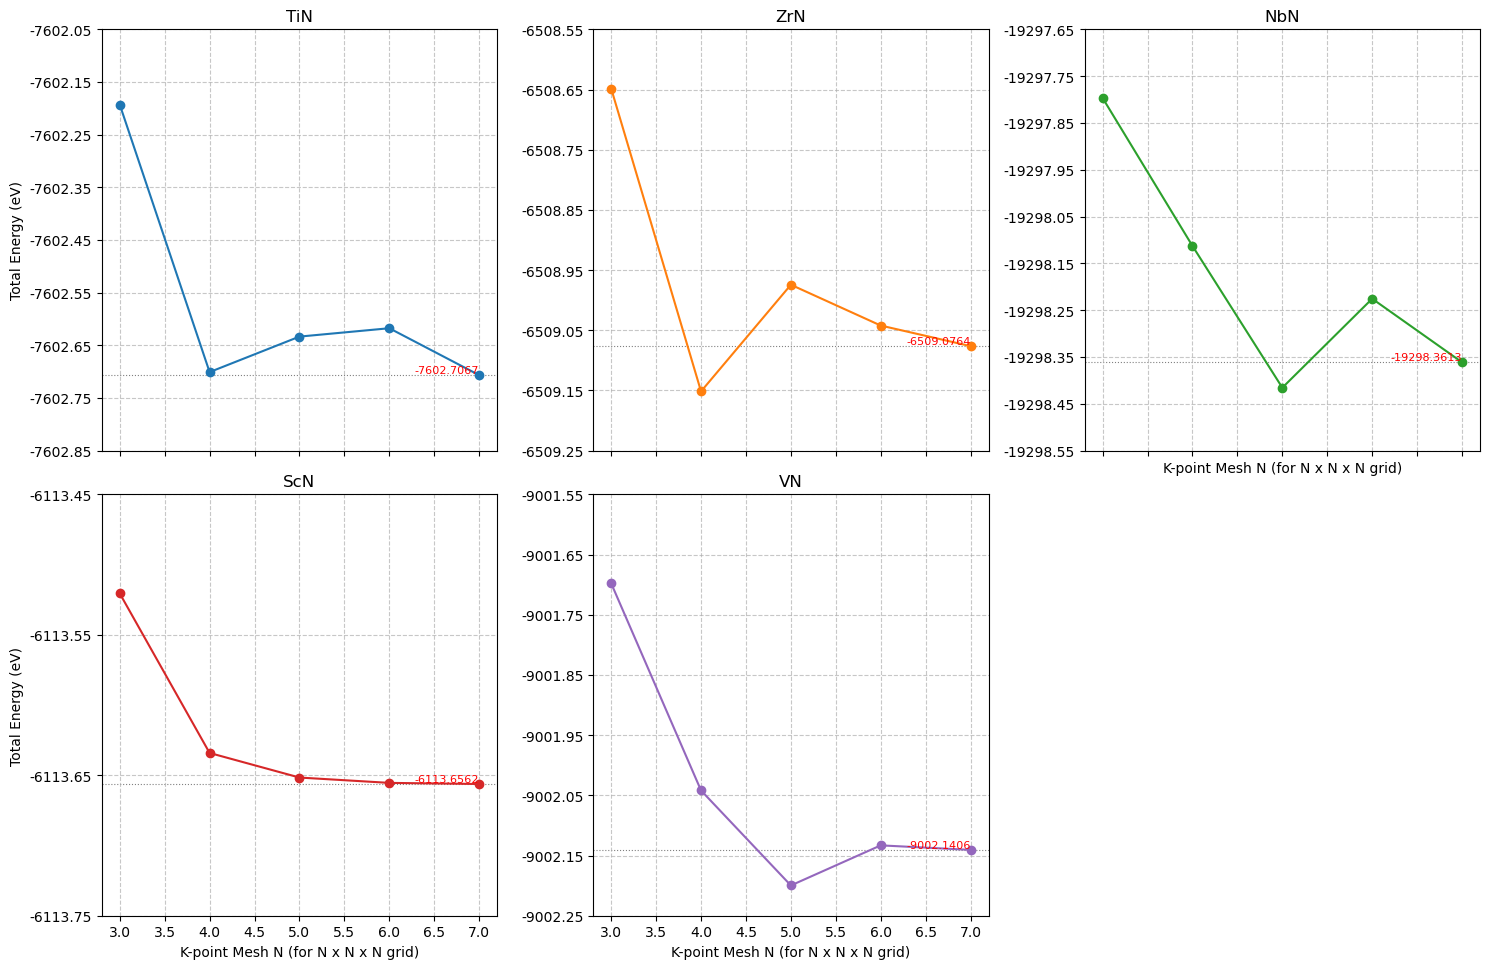

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv # We need this to read CSV files

# --- Configuration for reading the CSV file ---
input_filename = "k_pnts.csv" # Changed to CSV filename

# --- Data structures to hold parsed data ---
# This will store data like {k_mesh_N_value: {crystal_name: energy, ...}}
energies_data = {}
all_crystal_names = [] # To store the order of crystals from the header
k_mesh_N_values = [] # To store the N values from (N,N,N) k-point meshes

# --- Read and Parse the k_pnts.csv file ---
if not os.path.exists(input_filename):
    print(f"Error: The file '{input_filename}' was not found in the current directory.")
    print("Please make sure you have run the k-point calculation script to generate this CSV file.")
    exit() # Exit the script if the file doesn't exist

print(f"Reading data from '{input_filename}'...")

with open(input_filename, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Read header row
    header = next(reader) # Reads the first line which is the header
    
    # The first element is 'k_points', the rest are crystal names
    all_crystal_names = [name.strip() for name in header[1:]] 

    # Parse data rows
    for row in reader:
        if not row: # Skip empty rows
            continue
        try:
            # The first column is a string like "(3, 3, 3)". We need to extract '3'.
            kpt_str = row[0].strip()
            # Assuming kpt_str is always like "(N, N, N)", we can parse N
            # Extract the number inside the parentheses
            n_value = int(kpt_str.strip('()').split(',')[0].strip()) 
            
            if n_value not in k_mesh_N_values:
                k_mesh_N_values.append(n_value)
            
            # Initialize inner dictionary for this k-point N value if not already done
            if n_value not in energies_data:
                energies_data[n_value] = {}

            for j, crystal_name in enumerate(all_crystal_names):
                # Data for crystals starts from the second column (index 1) in CSV
                energy_str = row[j + 1].strip() 
                if energy_str == "Failed" or energy_str == "N/A":
                    energies_data[n_value][crystal_name] = energy_str # Store as string
                else:
                    energies_data[n_value][crystal_name] = float(energy_str)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse row: '{row}' - Error: {e}")
            continue

# Ensure k_mesh_N_values is sorted (important for plotting order)
k_mesh_N_values.sort()

print("Data successfully parsed.")

# --- Plotting the Convergence in Subplots ---

num_crystals = len(all_crystal_names)
n_cols = 3 # You can adjust this number of columns
n_rows = (num_crystals + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True)
axes = axes.flatten() # Flatten the axes array for easy iteration

#fig.suptitle(f'Total Energy Convergence with respect to K-point Mesh (Ecut = {fixed_ecutwfc_ev} eV)', fontsize=16, y=1.02)

# Define the desired Y-axis increment
Y_AXIS_INCREMENT = 0.1 # eV (Adjust as needed for k-point convergence)

# Iterate through each crystal and plot on its own subplot
for i, crystal in enumerate(all_crystal_names):
    ax = axes[i] # Get the current subplot axis
    
    crystal_energies = []
    corresponding_k_mesh_Ns = []

    for n_val in k_mesh_N_values:
        energy = energies_data[n_val].get(crystal)
        if isinstance(energy, float): # Only plot if the calculation was successful
            crystal_energies.append(energy)
            corresponding_k_mesh_Ns.append(n_val)
    
    if crystal_energies: # Only plot if there's valid data for this crystal
        ax.plot(corresponding_k_mesh_Ns, crystal_energies, marker='o', linestyle='-', label=crystal, color=f'C{i}')
        ax.set_title(f'{crystal}') # Subplot title is the crystal name
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # --- Set Y-axis ticks with a specific increment (0.1 eV) ---
        min_energy = min(crystal_energies)
        max_energy = max(crystal_energies)

        # Create a slightly larger range for the y-axis to ensure points aren't exactly on the edge
        y_lower_bound = np.floor(min_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        y_upper_bound = np.ceil(max_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        
        # Add a small buffer to the limits
        buffer = Y_AXIS_INCREMENT * 0.5
        ax.set_ylim(y_lower_bound - buffer, y_upper_bound + buffer)

        # Generate the tick locations
        y_ticks = np.arange(y_lower_bound - buffer, y_upper_bound + buffer + Y_AXIS_INCREMENT/2, Y_AXIS_INCREMENT)
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{val:.2f}' for val in y_ticks]) # Format labels to 2 decimal places

        # Add text for the converged value (the last point)
        if len(crystal_energies) > 0:
            last_energy = crystal_energies[-1]
            last_k_mesh_N = corresponding_k_mesh_Ns[-1]
            ax.text(last_k_mesh_N, last_energy, f'{last_energy:.4f}',
                    verticalalignment='bottom' if last_energy < np.mean(crystal_energies) else 'top',
                    horizontalalignment='right', fontsize=8, color='red')
            # Draw a horizontal line at the last energy for visual guidance
            ax.axhline(y=last_energy, color='gray', linestyle=':', linewidth=0.8, zorder=0) # zorder to keep line behind data

    else:
        ax.text(0.5, 0.5, 'No valid data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{crystal} (No Data)')
        print(f"No valid energy data to plot for {crystal}.")

# Set common X-axis label for the bottom row of plots
for i in range(n_cols):
    if (n_rows - 1) * n_cols + i < num_crystals: # Only set x-label on active subplots in the bottom row
        axes[(n_rows - 1) * n_cols + i].set_xlabel('K-point Mesh N (for N x N x N grid)')
    else: # If there's only one row, set on all relevant subplots
        axes[i].set_xlabel('K-point Mesh N (for N x N x N grid)')


# Set common Y-axis label for the leftmost column of plots
for i in range(n_rows):
    if i * n_cols < num_crystals: # Only set y-label on active subplots in the first column
        axes[i * n_cols].set_ylabel('Total Energy (eV)')


# Hide any unused subplots (if num_crystals is not a perfect multiple of n_cols)
for i in range(num_crystals, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap and labels from overlapping

# Save the plot to a file
plot_filename = "k_pnts_convergence_plot.png"
plt.savefig(plot_filename, dpi=300) # Save as PNG with 300 DPI for good quality
print(f"\nConvergence plot saved to {plot_filename}")

# Display the plot (optional, will show a pop-up window)
plt.show()